# Lab

```text
- Predict the sugar content in wines (regression)
```

In [1]:
# Built-in library
from typing import Any, Optional, Sequence, Union

# Standard imports
import numpy as np
import numpy.typing as npt
import pandas as pd
from sklearn.model_selection import train_test_split
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt

# Configure the backend
import matplotlib_inline.backend_inline

matplotlib_inline.backend_inline.set_matplotlib_formats("svg")
import seaborn as sns

# Custom import
from src.utilities import create_iris_data, smooth, load_data
from src.preprocessor import Standardizer, Normalizer


# Black code formatter (Optional)
%load_ext lab_black
# auto reload imports
%load_ext autoreload
%autoreload 2

In [2]:
fp = "../../data/wine_data.csv"

data = load_data(filename=fp)
data.head()

Shape of data: (1599, 12)



,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


#### Preprocess Data

```text
- Standardize/normalize the data.
- Binarize the output.
- Split the data using hold out CV.
- Create PyTorch datasets and dataloader objects.
- Create a custom class that supports batch normalization.
- Train and evaluate the model.
- Visualize the model results.
```

In [10]:
# Select all the features bar the target.
TARGET = "residual sugar"
X = data.drop(columns=[TARGET])  # Exclude residual sugar

# Normalize the data
norm_ = Normalizer(min_value=0, max_value=1)
X_norm = norm_.fit_transform(X=X)

X_norm.head()

,fixed acidity,volatile acidity,citric acid,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,0.247788,0.397260,0.00,0.106845,0.140845,0.098940,0.567548,0.606299,0.137725,0.153846,0.4
1,0.283186,0.520548,0.00,0.143573,0.338028,0.215548,0.494126,0.362205,0.209581,0.215385,0.4
2,0.283186,0.438356,0.04,0.133556,0.197183,0.169611,0.508811,0.409449,0.191617,0.215385,0.4
3,0.584071,0.109589,0.56,0.105175,0.225352,0.190813,0.582232,0.330709,0.149701,0.215385,0.6
4,0.247788,0.397260,0.00,0.106845,0.140845,0.098940,0.567548,0.606299,0.137725,0.153846,0.4


In [11]:
# Convert to Tensors
X = torch.Tensor(X_norm.to_numpy())

# Requred by PyTorch to be 2D instead of Rank 1 array
y = torch.Tensor(data[TARGET].to_numpy()).reshape(-1, 1)

# Split data
TEST_SIZE, RANDOM_STATE = 0.2, 123

X_train, X_validation, y_train, y_validation = train_test_split(
    X, y, test_size=TEST_SIZE, random_state=RANDOM_STATE
)

X_train.shape, X_validation.shape

(torch.Size([1279, 11]), torch.Size([320, 11]))

In [12]:
BATCH_SIZE, SHUFFLE = 16, True
DROP_LAST = True


# Create PyTorch datasets and dataloader objects.
train_data = TensorDataset(X_train, y_train)
validation_data = TensorDataset(X_validation, y_validation)

train_DL = DataLoader(
    dataset=train_data, batch_size=BATCH_SIZE, shuffle=SHUFFLE, drop_last=DROP_LAST
)
validation_DL = DataLoader(
    dataset=validation_data,
    batch_size=validation_data.tensors[0].shape[0],
)

In [33]:
# Build model architecture
class Net(nn.Module):
    """This is an ANN architecture that's used for regression."""

    def __init__(self, activation_func: str) -> None:
        super().__init__()
        self.activation_func = activation_func
        self.input = nn.Linear(11, 64)
        self.hidden = nn.Linear(64, 64)
        self.output = nn.Linear(64, 1)

    def forward(self, X: torch.Tensor) -> torch.Tensor:
        """This is used for the forward propagation."""
        act_func = getattr(torch.nn, self.activation_func)
        X = act_func()(self.input(X))
        X = act_func()(self.hidden(X))
        X = self.output(X)
        return X


def train_model(
    *,
    train_dataloader: DataLoader,
    validation_dataloader: DataLoader,
    activation_func: str,
) -> tuple[list[float]]:
    """This is used to train the ANN model."""
    net = Net(activation_func=activation_func)
    EPOCHS, LEARNING_RATE = 1_000, 0.01
    criterion, optimizer = nn.MSELoss(), torch.optim.SGD(
        params=net.parameters(), lr=LEARNING_RATE
    )
    train_loss, validation_loss = [], []

    for _ in np.arange(EPOCHS):
        net.train()
        batch_loss = []

        for X_, y_ in train_dataloader:
            # Reset gradients
            optimizer.zero_grad()

            # Forward prop and loss
            y_pred = net(X_)
            loss: torch.Tensor = criterion(y_pred, y_)

            # Back prop
            loss.backward()
            optimizer.step()

            # Batch loss
            batch_loss.append(loss.detach())

        # Training loss
        train_loss.append(np.mean(batch_loss))

        # Validation
        net.eval()

        X_val, y_val = next(iter(validation_dataloader))
        y_pred_val = net(X_val)
        loss_: torch.Tensor = criterion(y_pred_val, y_val)
        validation_loss.append(loss_.detach())
    return (train_loss, validation_loss, net)

In [35]:
train_loss, validation_loss, trained_model = train_model(
    train_dataloader=train_DL,
    validation_dataloader=validation_DL,
    activation_func="ReLU",
)

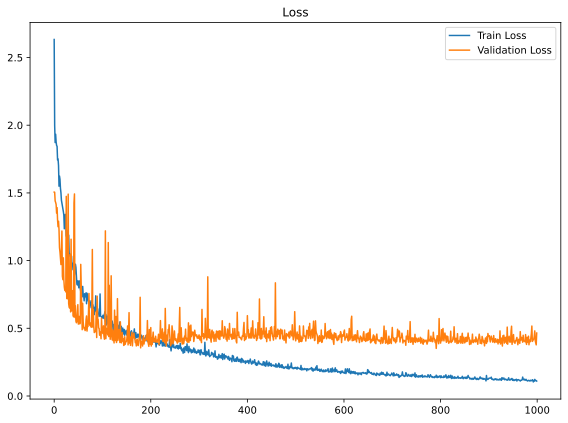

In [26]:
# Visualize the results
plt.figure(figsize=(8, 6))

plt.plot(train_loss, label="Train Loss")
plt.plot(validation_loss, label="Validation Loss")
plt.title("Loss")
plt.legend(loc="best")

plt.tight_layout()
plt.show()

#### Evaluate The Model

In [47]:
idx = 205
input_ = data.drop(columns=[TARGET]).iloc[idx].to_numpy()

# Convert the normalized input to a tensor
input_tensor = torch.Tensor(norm_.transform(input_))
expected_result = data[TARGET].iloc[idx]
(input_tensor, expected_result)

(tensor([0.7257, 0.1233, 0.7400, 0.1386, 0.1127, 0.0777, 0.6850, 0.3622, 0.2635,
         0.3692, 0.8000]),
 2.6)

In [45]:
trained_model(input_tensor)

tensor([2.8984], grad_fn=<AddBackward0>)